# Online Retail Dataset: Feature Engineering for Clustering

In this notebook, I'll create some features that will be used to perform
customer segmentation with clustering algorithms.

## Imports

In [1]:
from pathlib import Path
from typing import cast

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.axes import Axes
from mpl_toolkits.mplot3d.axes3d import Axes3D
from pandas.testing import assert_frame_equal
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler

from utils.online_retail import compute_rfm_attributes, compute_total_price, get_clean_data

## Prepare the data

In other notebooks, we've cleaned the original data, and computed the RFM
attributes. We're done with the RFM analysis, but we'll use those results
here. Specifically, we'll utilize recency, frequency and monetary value to
create new features.

Fortunately, we've defined a few functions that we can call to repeat the
steps mentioned above. We can prepare the data again with the aid of the code
that follows.

In [2]:
# Path to original dataset
file_path = Path.cwd().parents[1] / "data" / "online_retail.xlsx"
assert file_path.exists(), f"file doesn't exist: {file_path}"
assert file_path.is_file(), f"not a file: {file_path}"

In [3]:
# Get RFM attributes
df = (
    get_clean_data(file_path)
    .groupby("InvoiceNo", observed=True)
    .apply(compute_total_price, include_groups=False)
    .reset_index()
    .pipe(compute_rfm_attributes)
)
df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,3,7,4310.00
12348,76,4,1797.24
12349,19,1,1757.55
12350,311,1,334.40


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4338 entries, 12346 to 18287
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    4338 non-null   int64  
 1   Frequency  4338 non-null   int64  
 2   Monetary   4338 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 135.6 KB


## Correlations

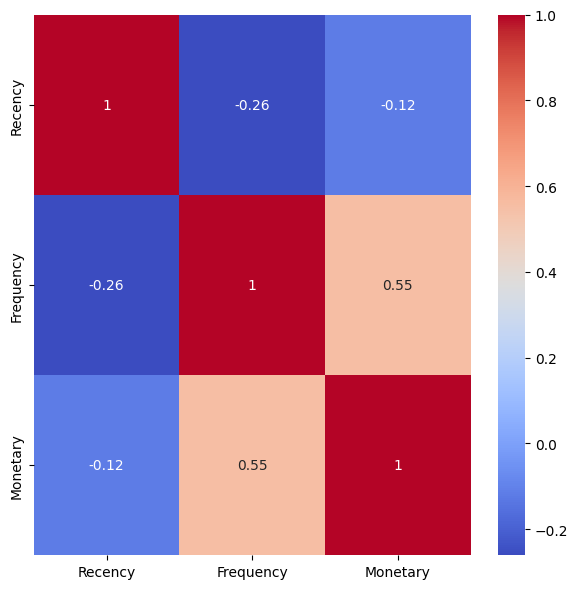

In [5]:
# Correlation between RFM attributes
fig, ax = plt.subplots(figsize=(6.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.heatmap(
    df[["Recency", "Frequency", "Monetary"]].corr(),
    annot=True,
    cmap=mpl.colormaps["coolwarm"],
    ax=ax,
)
plt.show()

In [6]:
# Introduce feature to replace `Monetary`
df["AvgSpent"] = df["Monetary"] / df["Frequency"]
assert df["AvgSpent"].isna().sum() == 0

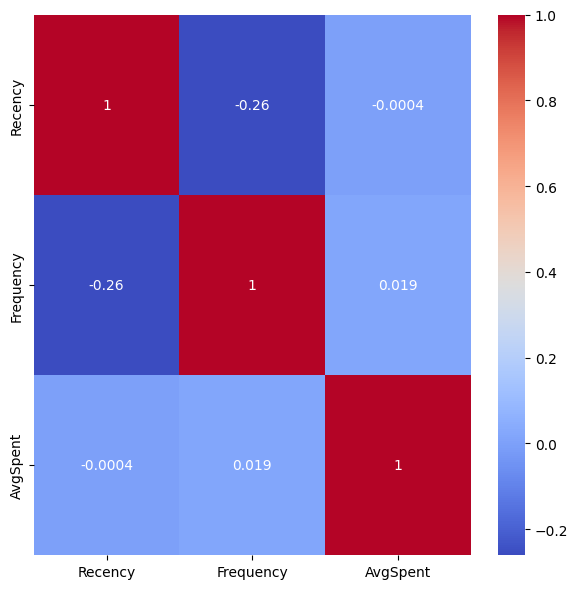

In [7]:
# Correlations with `Monetary` replaced
fig, ax = plt.subplots(figsize=(6.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.heatmap(
    df[["Recency", "Frequency", "AvgSpent"]].corr(),
    annot=True,
    cmap=mpl.colormaps["coolwarm"],
    ax=ax,
)
plt.show()

## Distributions

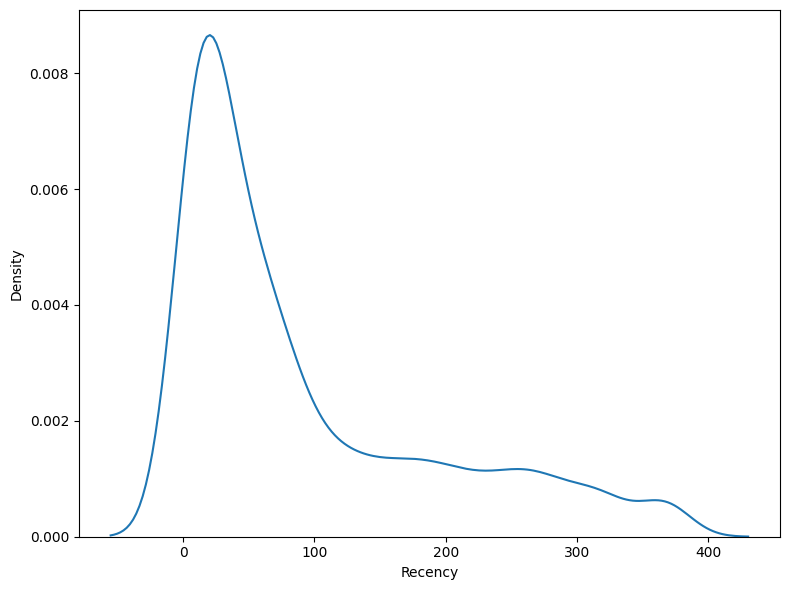

In [8]:
# Recency
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.kdeplot(data=df, x="Recency", ax=ax)
plt.show()

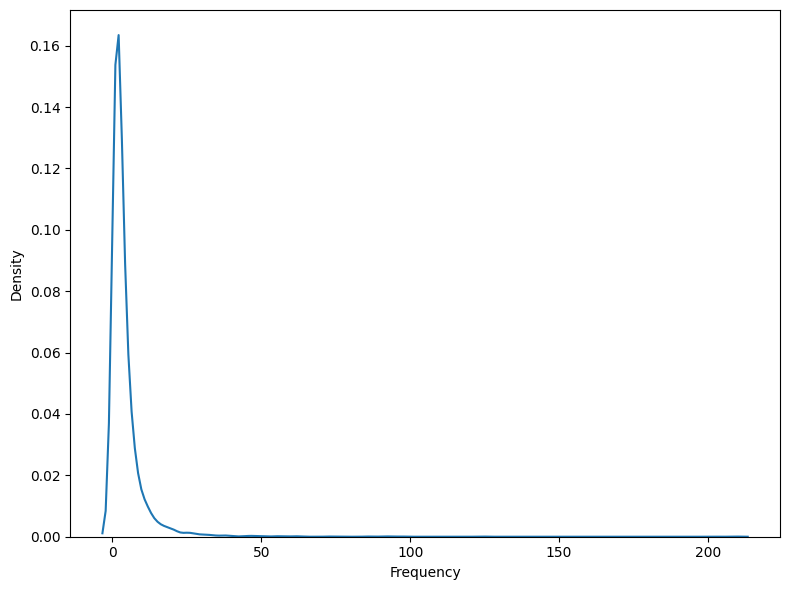

In [9]:
# Frequency
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.kdeplot(data=df, x="Frequency", ax=ax)
plt.show()

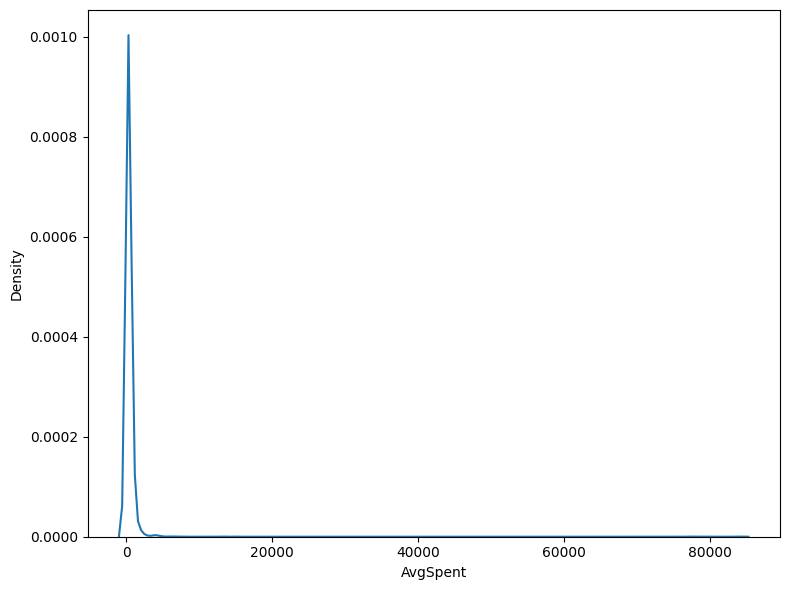

In [10]:
# AvgSpent
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.kdeplot(data=df, x="AvgSpent", ax=ax)
plt.show()

## Create features by using transforms
### Power transforms

In [11]:
# Box-Cox transform requires strictly positive input
assert (df["Recency"] > 0).all()
assert (df["Frequency"] > 0).all()
assert (df["AvgSpent"] > 0).all()

In [12]:
# Actual transformation
X = df[["Recency", "Frequency", "AvgSpent"]].to_numpy()
X_new = PowerTransformer(method="box-cox").fit_transform(X)
df = df.assign(
    PTRecency=X_new[:, 0],
    PTFrequency=X_new[:, 1],
    PTAvgSpent=X_new[:, 2],
)
del X_new
df.head()

,Recency,Frequency,Monetary,AvgSpent,PTRecency,PTFrequency,PTAvgSpent
CustomerID,,,,,,,
12346,326,1,77183.60,77183.600000,1.620274,-1.184682,6.759382
12347,3,7,4310.00,615.714286,-1.738803,1.159357,1.037005
12348,76,4,1797.24,449.310000,0.299813,0.664699,0.625716
12349,19,1,1757.55,1757.550000,-0.703409,-1.184682,2.370976
12350,311,1,334.40,334.400000,1.572616,-1.184682,0.235598


In [13]:
# New features have mean 0 and variance 1
df[["PTRecency", "PTFrequency", "PTAvgSpent"]].agg(["mean", "var"])

,PTRecency,PTFrequency,PTAvgSpent
mean,2.473305e-16,3.439695e-17,1.054840e-15
var,1.000231e+00,1.000231e+00,1.000231e+00


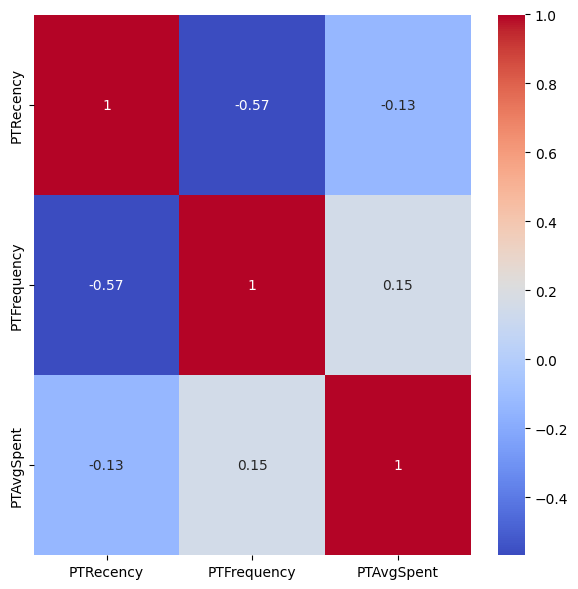

In [14]:
# Correlations
fig, ax = plt.subplots(figsize=(6.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.heatmap(
    df[["PTRecency", "PTFrequency", "PTAvgSpent"]].corr(),
    annot=True,
    cmap=mpl.colormaps["coolwarm"],
    ax=ax,
)
plt.show()

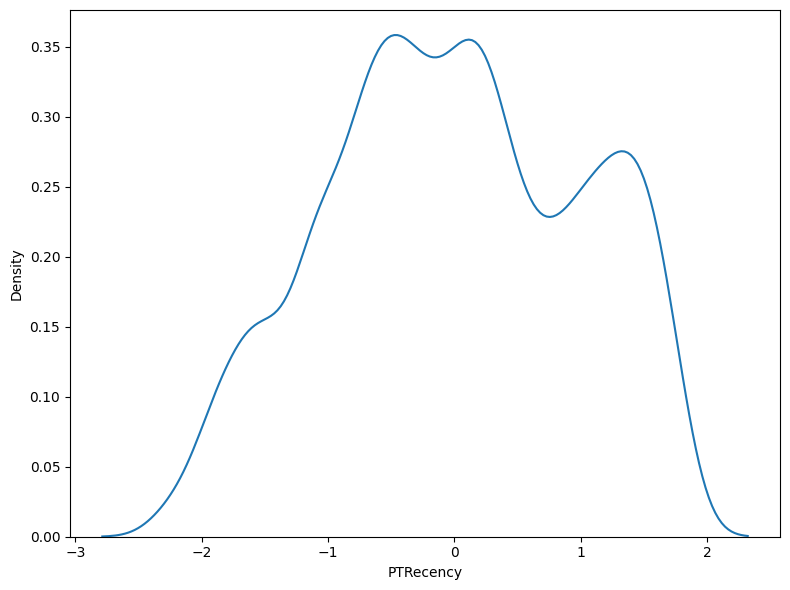

In [15]:
# Distribution of PTRecency: NOT Gaussian-like
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.kdeplot(data=df, x="PTRecency", ax=ax)
plt.show()

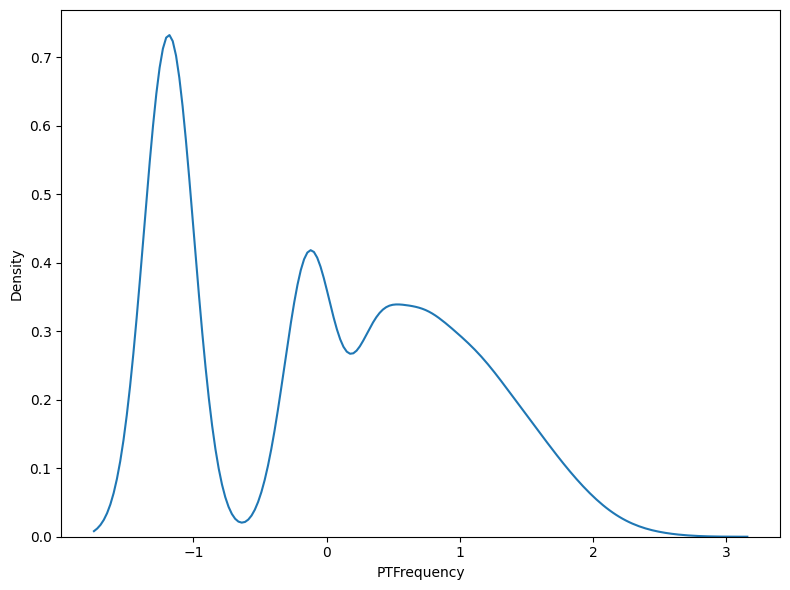

In [16]:
# Distribution of PTFrequency: NOT Gaussian-like
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.kdeplot(data=df, x="PTFrequency", ax=ax)
plt.show()

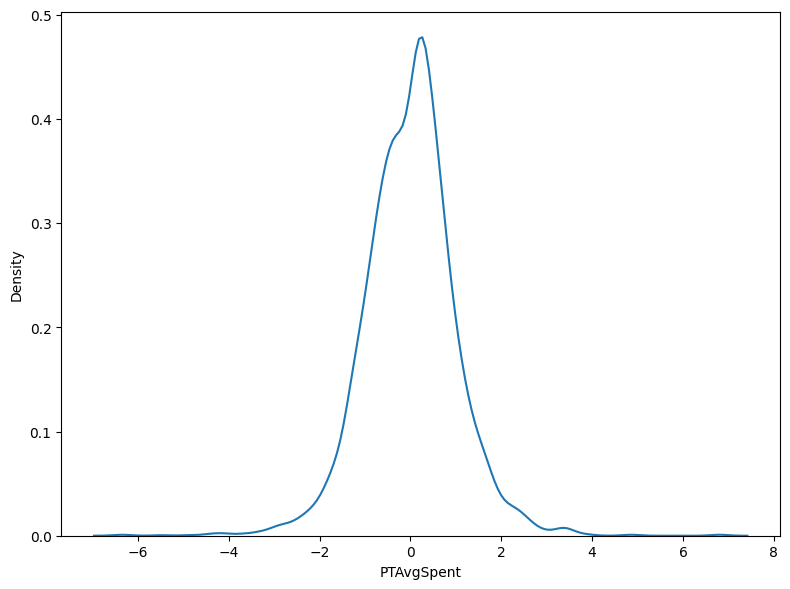

In [17]:
# Distribution of PTAvgSpent: Gaussian-like!!!
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.kdeplot(data=df, x="PTAvgSpent", ax=ax)
plt.show()

### Quantile transform

In [18]:
qt = QuantileTransformer(n_quantiles=100, output_distribution="normal", random_state=333)
X_new = qt.fit_transform(X)
df = df.assign(
    QTRecency=X_new[:, 0],
    QTFrequency=X_new[:, 1],
    QTAvgSpent=X_new[:, 2],
)
del qt
del X_new
df.head()

,Recency,Frequency,Monetary,AvgSpent,PTRecency,PTFrequency,PTAvgSpent,QTRecency,QTFrequency,QTAvgSpent
CustomerID,,,,,,,,,,
12346,326,1,77183.60,77183.600000,1.620274,-1.184682,6.759382,1.789135,-5.199338,3.132516
12347,3,7,4310.00,615.714286,-1.738803,1.159357,1.037005,-1.690622,1.073988,1.178573
12348,76,4,1797.24,449.310000,0.299813,0.664699,0.625716,0.304243,0.515705,0.742489
12349,19,1,1757.55,1757.550000,-0.703409,-1.184682,2.370976,-0.635270,-5.199338,2.167668
12350,311,1,334.40,334.400000,1.572616,-1.184682,0.235598,1.629275,-5.199338,0.246281


In [19]:
# New features need to be standardized
df[["QTRecency", "QTFrequency", "QTAvgSpent"]].agg(["mean", "var"])

,QTRecency,QTFrequency,QTAvgSpent
mean,-0.007012,-1.419806,-0.002244
var,1.231496,7.784932,0.985778


In [20]:
# Standardize new features
X = df[["QTRecency", "QTFrequency", "QTAvgSpent"]].to_numpy()
X_new = StandardScaler().fit_transform(X)
df = df.assign(
    QTRecency=X_new[:, 0],
    QTFrequency=X_new[:, 1],
    QTAvgSpent=X_new[:, 2],
)
del X
del X_new
df.head()

,Recency,Frequency,Monetary,AvgSpent,PTRecency,PTFrequency,PTAvgSpent,QTRecency,QTFrequency,QTAvgSpent
CustomerID,,,,,,,,,,
12346,326,1,77183.60,77183.600000,1.620274,-1.184682,6.759382,1.618734,-1.354755,3.157656
12347,3,7,4310.00,615.714286,-1.738803,1.159357,1.037005,-1.517312,0.893888,1.189442
12348,76,4,1797.24,449.310000,0.299813,0.664699,0.625716,0.280511,0.693774,0.750173
12349,19,1,1757.55,1757.550000,-0.703409,-1.184682,2.370976,-0.566202,-1.354755,2.185762
12350,311,1,334.40,334.400000,1.572616,-1.184682,0.235598,1.474664,-1.354755,0.250340


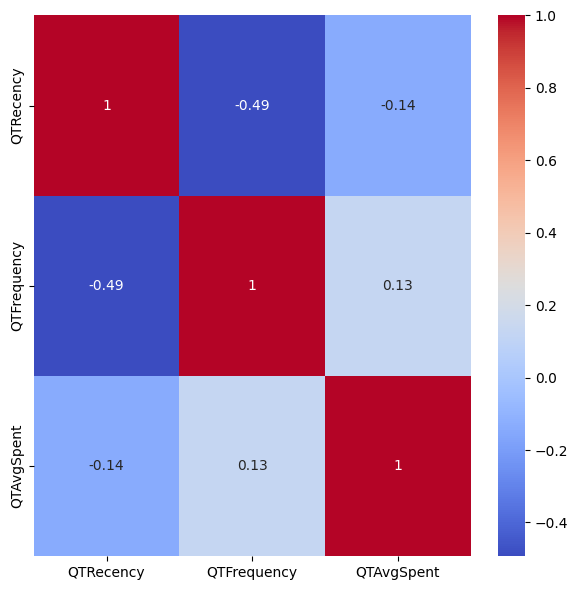

In [21]:
# Correlations
fig, ax = plt.subplots(figsize=(6.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.heatmap(
    df[["QTRecency", "QTFrequency", "QTAvgSpent"]].corr(),
    annot=True,
    cmap=mpl.colormaps["coolwarm"],
    ax=ax,
)
plt.show()

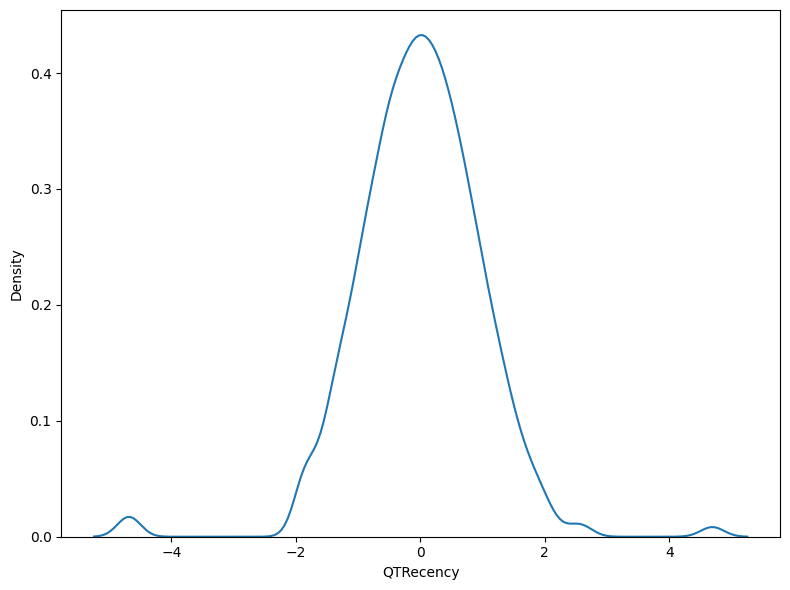

In [22]:
# Distribution of QTRecency: Gaussian-like!!!
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.kdeplot(data=df, x="QTRecency", ax=ax)
plt.show()

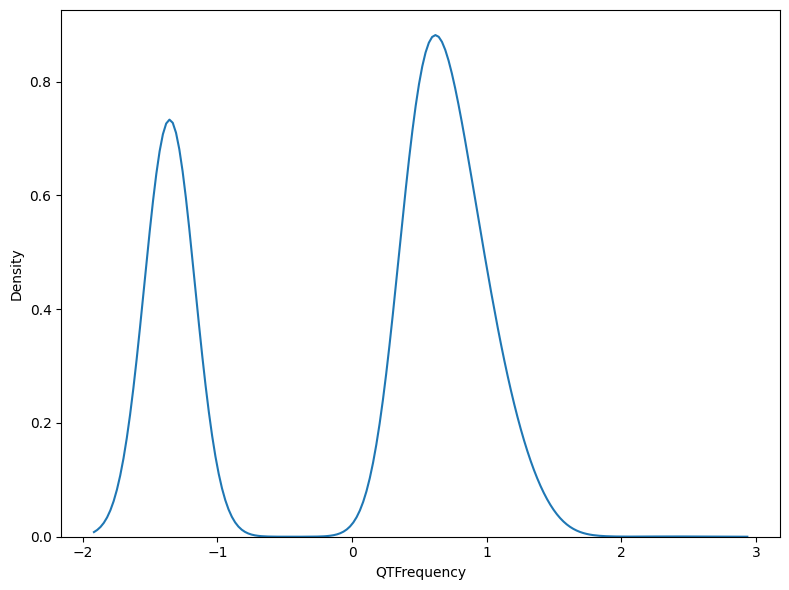

In [23]:
# Distribution of QTFrequency: NOT Gaussian-like
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.kdeplot(data=df, x="QTFrequency", ax=ax)
plt.show()

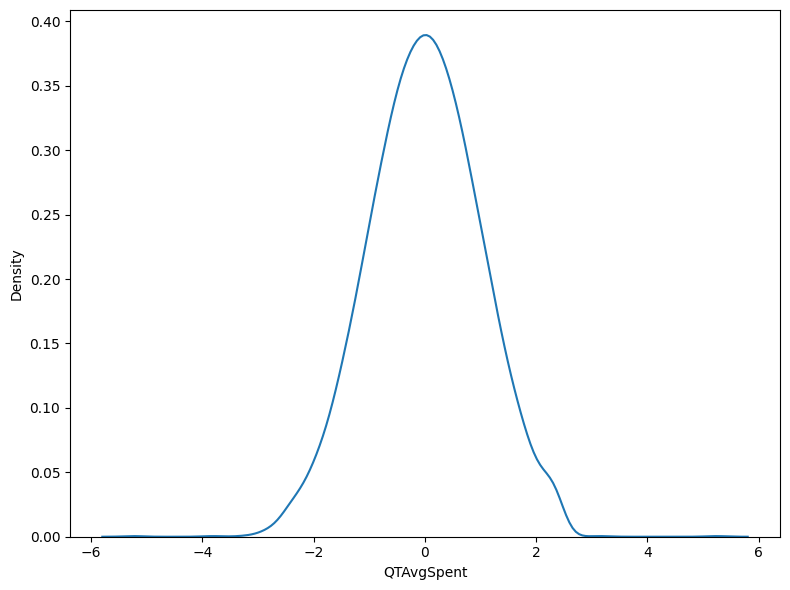

In [24]:
# Distribution of QTAvgSpent: Gaussian-like!!!
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.kdeplot(data=df, x="QTAvgSpent", ax=ax)
plt.show()

## 3D Plots

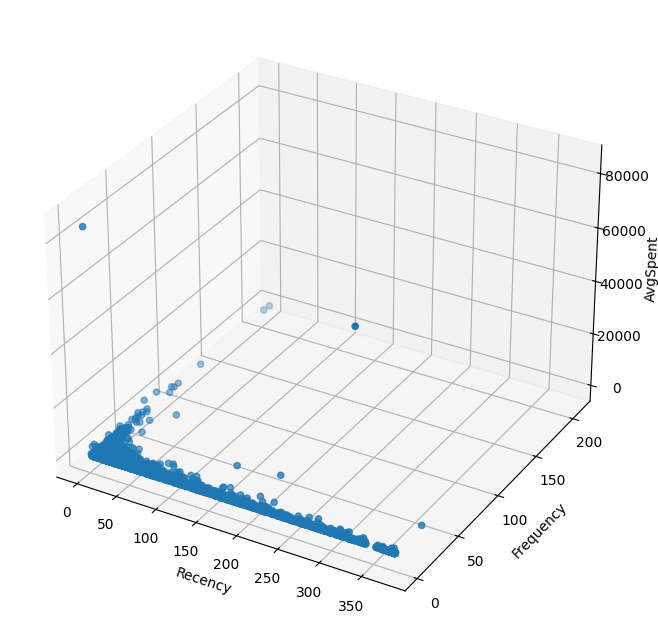

In [25]:
# For comparison, plot "original" features
fig = plt.figure(figsize=(8.0, 6.5), layout="tight")
ax = fig.add_subplot(projection="3d")
ax = cast(Axes3D, ax)
ax.scatter(df.Recency, df.Frequency, df.AvgSpent)
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("AvgSpent")
plt.show()

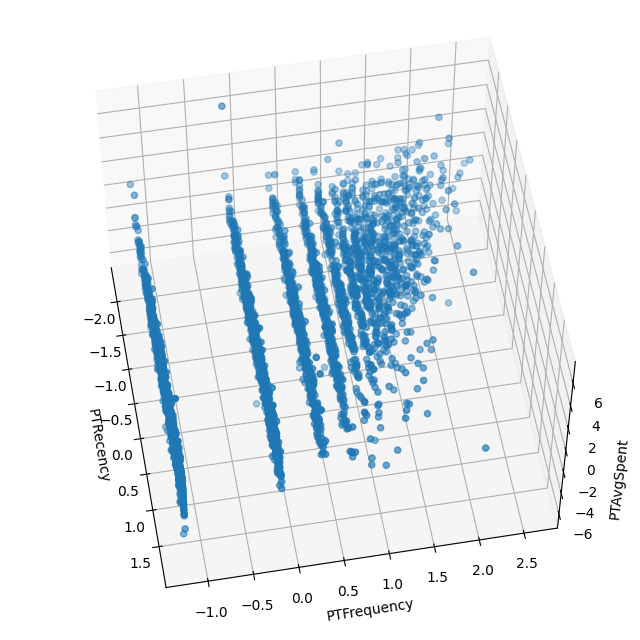

In [26]:
# Features yielded by power transform
fig = plt.figure(figsize=(8.0, 6.5), layout="tight")
ax = fig.add_subplot(projection="3d")
ax = cast(Axes3D, ax)
ax.scatter(df.PTRecency, df.PTFrequency, df.PTAvgSpent)
ax.view_init(elev=55.0, azim=-10.0, roll=0.0)
ax.set_xlabel("PTRecency")
ax.set_ylabel("PTFrequency")
ax.set_zlabel("PTAvgSpent")
plt.show()

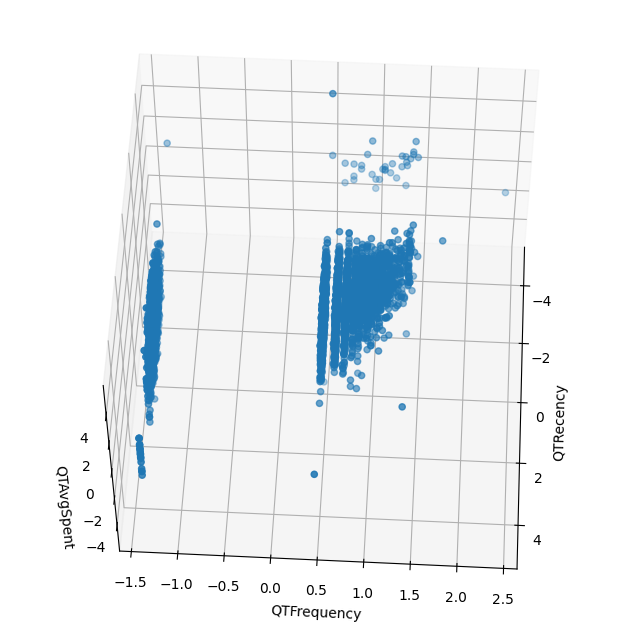

In [27]:
# Features yielded by quantile transform
fig = plt.figure(figsize=(8.0, 6.5), layout="tight")
ax = fig.add_subplot(projection="3d")
ax = cast(Axes3D, ax)
ax.scatter(df.QTRecency, df.QTFrequency, df.QTAvgSpent)
ax.view_init(elev=55.0, azim=3.0, roll=0.0)
ax.set_xlabel("QTRecency")
ax.set_ylabel("QTFrequency")
ax.set_zlabel("QTAvgSpent")
plt.show()

Based on the above figures, the power transform features seem the most
useful. After all, in the corresponding plot, we can see a few clusters quite
clearly.

## Save features

In [28]:
# Just checking everything's OK
df.head()

,Recency,Frequency,Monetary,AvgSpent,PTRecency,PTFrequency,PTAvgSpent,QTRecency,QTFrequency,QTAvgSpent
CustomerID,,,,,,,,,,
12346,326,1,77183.60,77183.600000,1.620274,-1.184682,6.759382,1.618734,-1.354755,3.157656
12347,3,7,4310.00,615.714286,-1.738803,1.159357,1.037005,-1.517312,0.893888,1.189442
12348,76,4,1797.24,449.310000,0.299813,0.664699,0.625716,0.280511,0.693774,0.750173
12349,19,1,1757.55,1757.550000,-0.703409,-1.184682,2.370976,-0.566202,-1.354755,2.185762
12350,311,1,334.40,334.400000,1.572616,-1.184682,0.235598,1.474664,-1.354755,0.250340


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4338 entries, 12346 to 18287
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Recency      4338 non-null   int64  
 1   Frequency    4338 non-null   int64  
 2   Monetary     4338 non-null   float64
 3   AvgSpent     4338 non-null   float64
 4   PTRecency    4338 non-null   float64
 5   PTFrequency  4338 non-null   float64
 6   PTAvgSpent   4338 non-null   float64
 7   QTRecency    4338 non-null   float64
 8   QTFrequency  4338 non-null   float64
 9   QTAvgSpent   4338 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 372.8 KB


In [30]:
# Save to CSV
out_file = file_path.parent / "clustering_features.csv"
df.to_csv(out_file, index=True)

## Summarizing through functions

In [31]:
def get_original_features(file_path: Path) -> pd.DataFrame:
    return (
        get_clean_data(file_path)
        .groupby("InvoiceNo", observed=True)
        .apply(compute_total_price, include_groups=False)
        .reset_index()
        .pipe(compute_rfm_attributes)
        .assign(AvgSpent=df["Monetary"] / df["Frequency"])
        .drop(columns="Monetary")
    )

In [32]:
def add_power_transform_features(df: pd.DataFrame) -> pd.DataFrame:
    X = df[["Recency", "Frequency", "AvgSpent"]].to_numpy()  # noqa: N806
    X_new = PowerTransformer(method="box-cox").fit_transform(X)  # noqa: N806
    return df.assign(PTRecency=X_new[:, 0], PTFrequency=X_new[:, 1], PTAvgSpent=X_new[:, 2])

In [33]:
def add_quantile_transform_features(df: pd.DataFrame) -> pd.DataFrame:
    X = df[["Recency", "Frequency", "AvgSpent"]].to_numpy()  # noqa: N806
    qt = QuantileTransformer(n_quantiles=100, output_distribution="normal", random_state=333)
    X_new_1 = qt.fit_transform(X)  # noqa: N806
    X_new_2 = StandardScaler().fit_transform(X_new_1)  # noqa: N806
    return df.assign(QTRecency=X_new_2[:, 0], QTFrequency=X_new_2[:, 1], QTAvgSpent=X_new_2[:, 2])

In [34]:
# Quick check
df_funcs = (
    get_original_features(Path.cwd().parents[1] / "data" / "online_retail.xlsx")
    .pipe(add_power_transform_features)
    .pipe(add_quantile_transform_features)
)
assert_frame_equal(df_funcs, df.drop(columns="Monetary"))
del df_funcs

In [35]:
def compute_and_save_features(file_path: Path) -> None:
    df = (
        get_original_features(file_path)
        .pipe(add_power_transform_features)
        .pipe(add_quantile_transform_features)
    )
    out_file = file_path.parent / "clustering_features.csv"
    df.to_csv(out_file, index=True)

In [36]:
compute_and_save_features(Path.cwd().parents[1] / "data" / "online_retail.xlsx")